## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
SAVE_BEST = [True, False]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 5s 102us/step - loss: 0.5521 - accuracy: 0.8396 - val_loss: 1.6597 - val_accuracy: 0.4840
Epoch 47/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.5357 - accuracy: 0.8453 - val_loss: 1.6580 - val_accuracy: 0.4882
Epoch 48/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.5172 - accuracy: 0.8538 - val_loss: 1.6976 - val_accuracy: 0.4851
Epoch 49/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.5022 - accuracy: 0.8588 - val_loss: 1.6966 - val_accuracy: 0.4885
Epoch 50/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.4861 - accuracy: 0.8651 - val_loss: 1.7161 - val_accuracy: 0.4868
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
____________________________________________________

50000/50000 [==============================] - 5s 93us/step - loss: 0.6616 - accuracy: 0.7945 - val_loss: 1.5850 - val_accuracy: 0.4945
Epoch 42/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.6444 - accuracy: 0.8025 - val_loss: 1.5856 - val_accuracy: 0.4875
Epoch 43/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.6253 - accuracy: 0.8097 - val_loss: 1.5819 - val_accuracy: 0.4916
Epoch 44/50
50000/50000 [==============================] - 5s 105us/step - loss: 0.6098 - accuracy: 0.8148 - val_loss: 1.5888 - val_accuracy: 0.4974
Epoch 45/50
50000/50000 [==============================] - 5s 105us/step - loss: 0.5903 - accuracy: 0.8238 - val_loss: 1.6057 - val_accuracy: 0.4914
Epoch 46/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.5698 - accuracy: 0.8328 - val_loss: 1.6251 - val_accuracy: 0.4879
Epoch 47/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.5541 - accuracy: 0.8381 - val_loss: 1

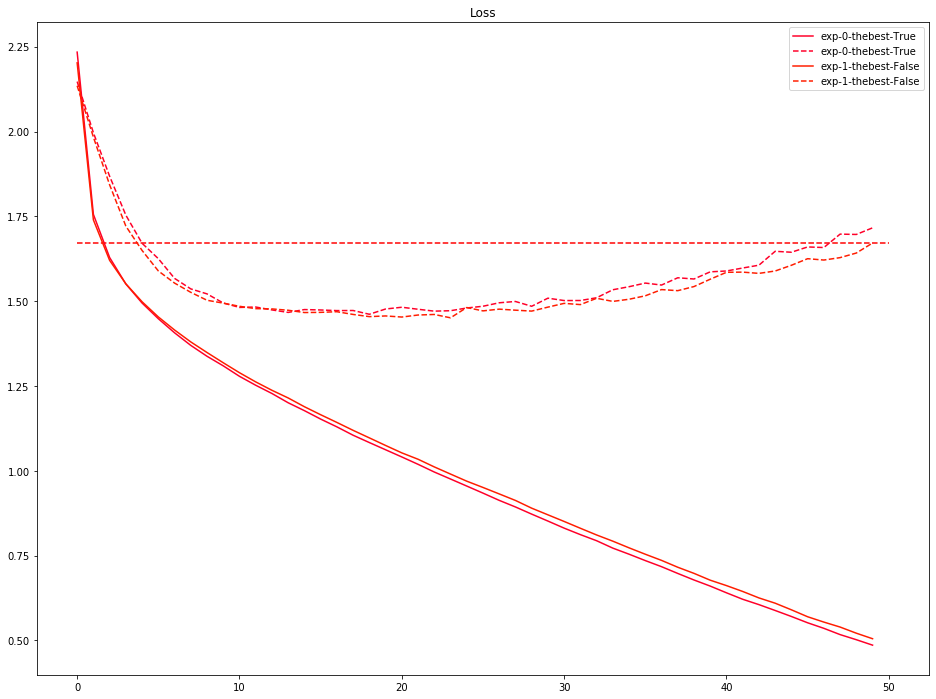

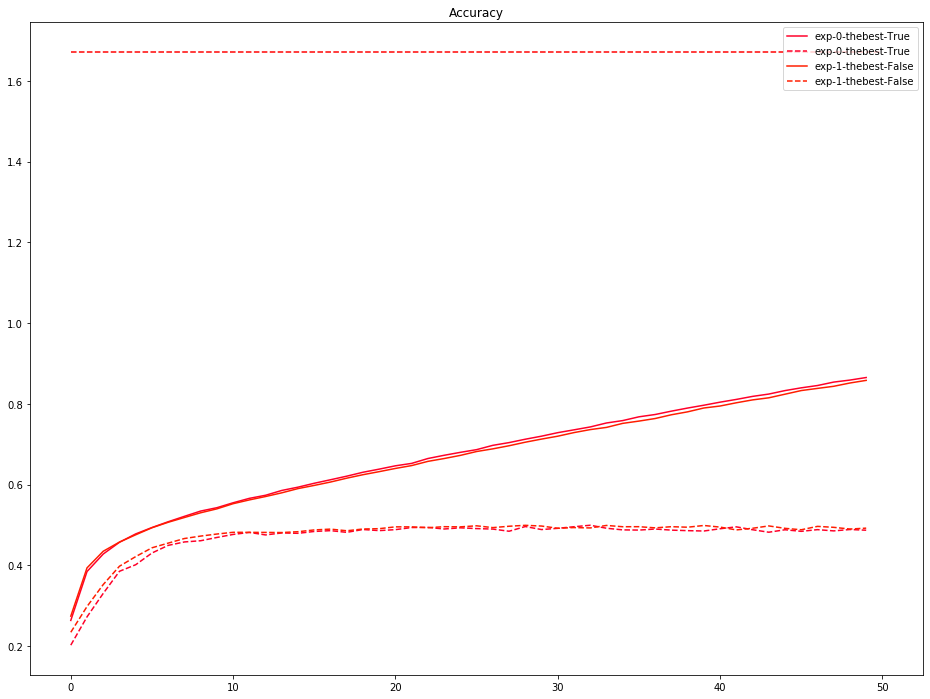

In [7]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
results = {}
for i, best in enumerate(SAVE_BEST):
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                                 monitor="val_loss", 
                                 save_best_only=best,
                                 save_weights_only=True)

    """Code Here
    撰寫你的訓練流程並將結果用 dictionary 紀錄
    """
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "exp-%s-thebest-%s" % (i, best)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()


Epoch 1/1
10000/10000 [==============================] - 1s 140us/step


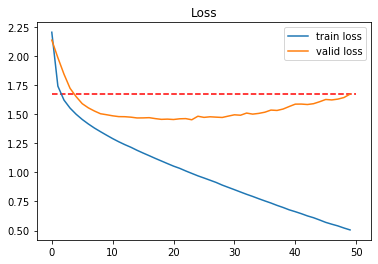

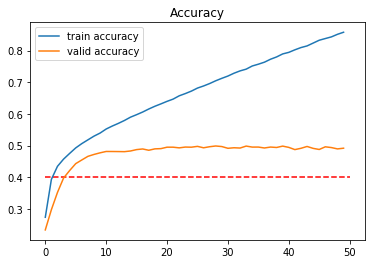

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
model1 = build_mlp(input_shape=x_train.shape[1:])
model1.load_weights("./tmp.h5", by_name = True)
model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model1.fit(x_train, y_train)
loss_loadback, acc_loadback = model1.evaluate(x_test, y_test)

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()